# Analyzing Streamer Data on Twitch and Predicting Revenue

Twitch is an online streaming platform known for its unique live-streamed content and its massive popularity. Launched in 2011, Twitch has become one of the largest websites with 30 million daily users and thousands of streams on at any time. Content creators, known as streamers, can broadcast anything from video games to music and arts for their internet audiences. The top streamers can reach millions of followers and rake in dizzying amounts of money.

I compiled data showing the statistics of the top 1000 Twitch streamers including information like views, followers, and revenue. This tutorial analyzes these statistics and presents a predictive model of success on Twitch.

## Data Scraping

First, let's scrape the chart data. The first chart is all Twitch statistics for the top 1000 streamers and the second chart is earnings of the top 100 streamers from July 2019 to September 2021.

In [150]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
!pip install tabulate
from tabulate import tabulate
from cycler import cycler
default_cycler = (cycler(color=['r', 'g', 'b', 'y']) +
                  cycler(linestyle=['-', '--', ':', '-.']))
import warnings
warnings.filterwarnings('ignore')

In [151]:
df = pd.read_csv("twitch.csv")
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


In [190]:
rev = pd.read_csv("rev.csv")
rev.head()

,Rank,Streamer,Payout
0,1,CriticalRole,9626712.16
1,2,xQcOW,8454427.17
2,3,summit1g,5847541.17
3,4,Tfue,5295582.44
4,5,NICKMERCS,5096642.12


Let's familiarize ourselves more with the first dataset. We can look at its statistical properties in pandas.

In [154]:
print("Mean:\n"+df.mean().to_markdown())
print("Median:\n"+df.median().to_markdown())
print("std:\n"+df.std().to_markdown())
print("Min:\n"+df.min().to_markdown())
print("Max:\n"+df.max().to_markdown())

Mean:
|                      |                0 |
|:---------------------|-----------------:|
| Watch time(Minutes)  |      4.18428e+08 |
| Stream time(minutes) | 120515           |
| Peak viewers         |  37065.1         |
| Average viewers      |   4781.04        |
| Followers            | 570054           |
| Followers gained     | 205519           |
| Views gained         |      1.16682e+07 |
| Partnered            |      0.978       |
| Mature               |      0.23        |
Median:
|                      |                0 |
|:---------------------|-----------------:|
| Watch time(Minutes)  |      2.34991e+08 |
| Stream time(minutes) | 108240           |
| Peak viewers         |  16676           |
| Average viewers      |   2425           |
| Followers            | 318063           |
| Followers gained     |  98352           |
| Views gained         |      6.45632e+06 |
| Partnered            |      1           |
| Mature               |      0           |
std:
|            

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Channel               1000 non-null   object
 1   Watch time(Minutes)   1000 non-null   int64 
 2   Stream time(minutes)  1000 non-null   int64 
 3   Peak viewers          1000 non-null   int64 
 4   Average viewers       1000 non-null   int64 
 5   Followers             1000 non-null   int64 
 6   Followers gained      1000 non-null   int64 
 7   Views gained          1000 non-null   int64 
 8   Partnered             1000 non-null   bool  
 9   Mature                1000 non-null   bool  
 10  Language              1000 non-null   object
dtypes: bool(2), int64(7), object(2)
memory usage: 72.4+ KB


Here we can see the table contains 1000 points of data with 11 columns. We will perform different statistical analyses depending on the datatype of each column.

## Exploratory Analysis and Visualization

Seaborn and Matplotlib have a lot of tools to help analyze and visualize large datasets. Let's break down the data and see what it has to say.

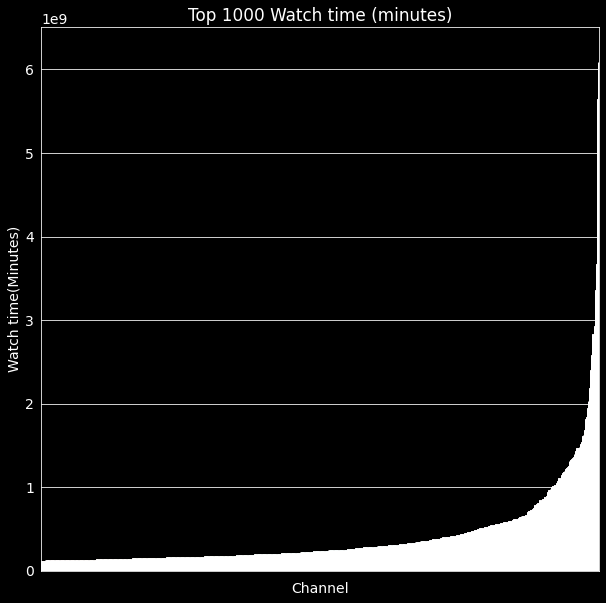

In [84]:
df.sort_values(by=['Watch time(Minutes)'])
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Watch time(Minutes)"]).set(xticklabels=[])
# plt.title("Comparing Top 25 Stream time(minutes)")
# plt.rc('axes', prop_cycle=default_cycler)
# fig = plt.figure()
# fig.set_facecolor('b')
# print(fig)
plt.title("Top 1000 Watch time (minutes)")
plt.show()

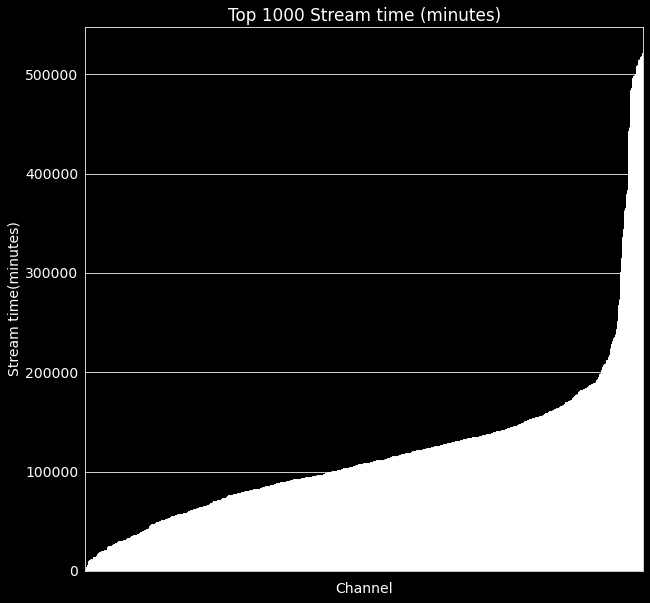

In [85]:
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Stream time(minutes)"]).set(xticklabels=[])
plt.title("Top 1000 Stream time (minutes)")
plt.show()

This shows the watch times and stream times of all the top 1000 streamers. Both are sorted by channels with most watch time. By eyeing the information, we can see that streamers with higher stream times tend to get higher watch times. We can also see that both of these graphs are not linear and that they both show a distinct outlier population of about 25 top streamers who spend the most time on Twitch and attract the largest crowds. These streamers are considered internet celebrities and are also the streamers with the most Twitch-savvy audiences. 

Looking again at the graph for stream time, we see a top streamer outlier population at the edge but also looking at the entire data, it seems that the whole top 1000 streamers set itself is an outlier, since there's a dip at the end. I guess that it dips at the minimum end to the millions of amateur streamers who stream far less than professionals. I found this interesting, because it's like there is another larger population of professional top streamers who aren't as visible as the celebrity streamers but still carry signifigant weight on Twitch.

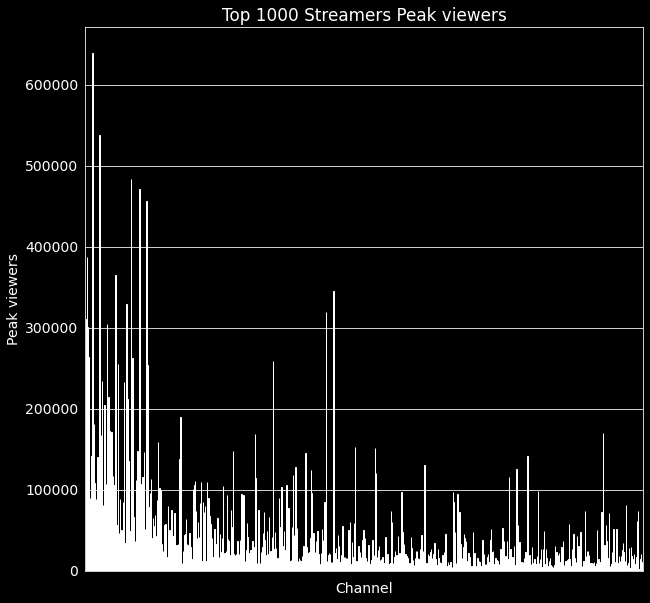

In [86]:
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Peak viewers"]).set(xticklabels=[])
plt.title("Top 1000 Streamers Peak viewers")
plt.show()

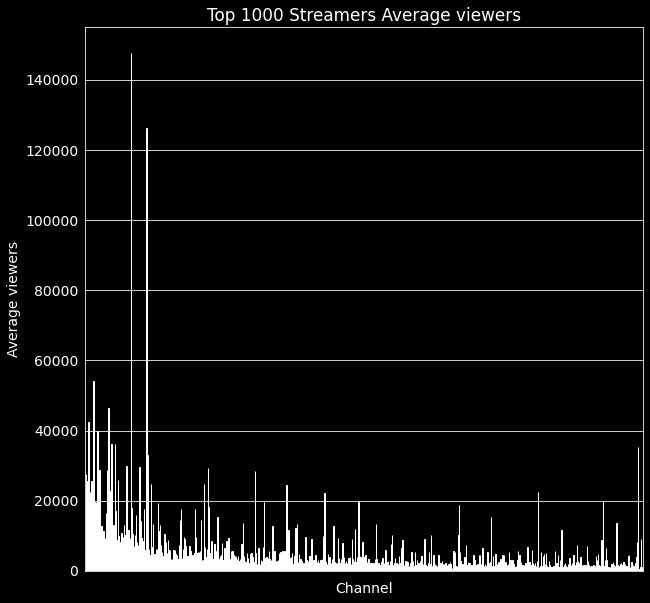

In [87]:
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Average viewers"]).set(xticklabels=[])
plt.title("Top 1000 Streamers Average viewers")
plt.show()

These graphs show peak viewers and average viewers sorted by channels with most watch time. Looking at the data, there is a correlation between watch time and peak viewers but there are also a lot of spikes and outliers. The random element of internet virality can explain how so many outliers can be present in this graph. Looking at the average viewers graph, there also is a correlation between watch time and average viewers. There are also outliers, but they aren't as steep.

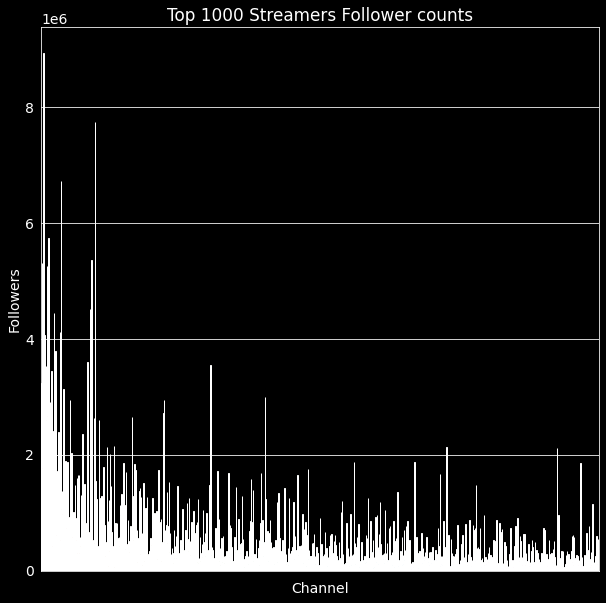

In [88]:
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Followers"]).set(xticklabels=[])
plt.title("Top 1000 Streamers Follower counts")
plt.show()

This is the graph of followers of each channel sorted by watch time. It is similar to the viewers graphs, with a loose correlation to watch time but with a lot of outliers.

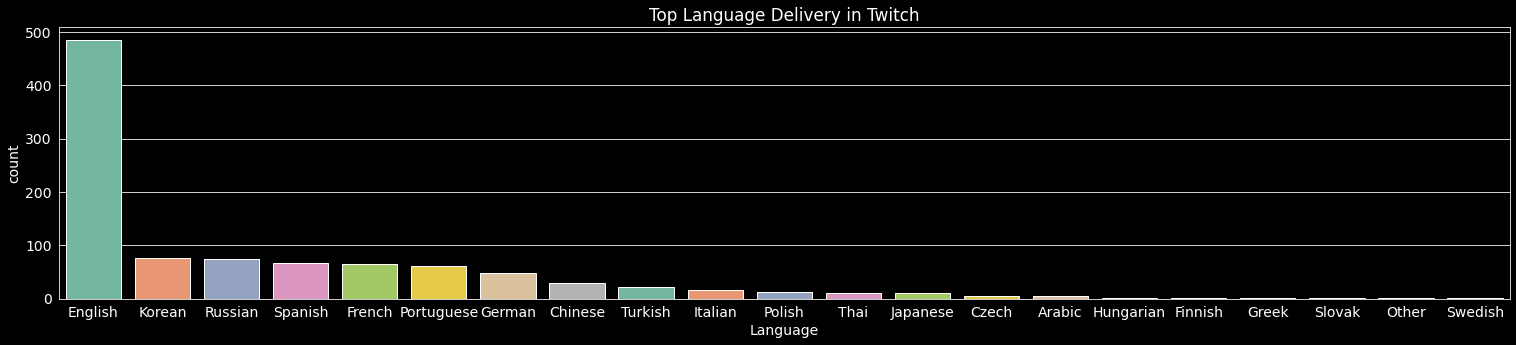

In [81]:
plt.figure(figsize=(26, 5))
plt.title("Top Languages on Twitch")
plot = sns.countplot(x="Language", data=df, order=df["Language"].value_counts().index, palette="Set2")

This graphs shows the distribution of languages used throughout Twitch. This statistic refers to what language a streamer is categorized under, even if they speak multiple languages. It is pretty clear that Twitch is English dominated, but there are also relevant commuities in many other languages, especially Korean, Russian, Spanish, French, Portuguese, and German.

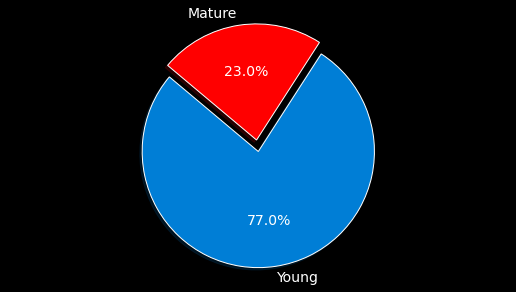

In [89]:
plt.pie(df.groupby("Mature").count()["Channel"].values,
        explode=[0.1, 0],
        labels=["All Ages", "Mature"], 
        colors=["#007ED6", "#FF0000"], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140)

plt.axis("equal")
plt.show()

Looking at the distribution of mature streams and all ages streams, a majority of streams are all ages. Let's compare the top 1000 to the top 100 to the top 25 to see if the distribution changes.

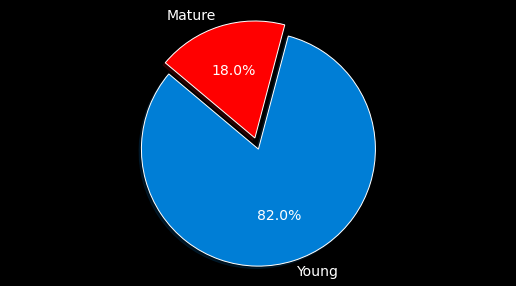

In [91]:
plt.pie(df.head(100).groupby("Mature").count()["Channel"].values,
        explode=[0.1, 0],
        labels=["All Ages", "Mature"], 
        colors=["#007ED6", "#FF0000"], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140)

plt.axis("equal")
plt.show()

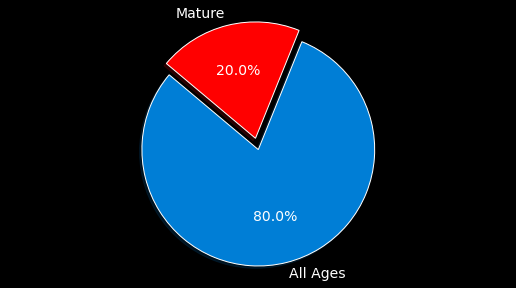

In [92]:
plt.pie(df.head(25).groupby("Mature").count()["Channel"].values,
        explode=[0.1, 0],
        labels=["All Ages", "Mature"], 
        colors=["#007ED6", "#FF0000"], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140)

plt.axis("equal")
plt.show()

The distribution actually stays about the same at all levels of watch time. I would expect there to be more friendly content among more popular streamers, but apparently popularity and content rating don't have a strong correlation on Twitch.

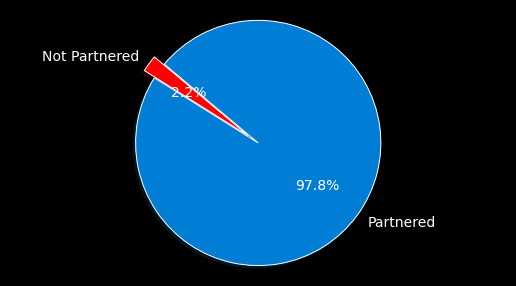

In [93]:
plt.pie(df.groupby("Partnered").count()["Channel"].values,
        explode=[0.1, 0],
        labels=["Not Partnered", "Partnered"], 
        colors=["#FF0000", "#007ED6"], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140)

plt.axis("equal")
plt.show()

This chart shows the distribution of partnered to not partnered streamers on Twitch. Partnership is a form of official recognition from Twitch that comes with bonus commision to streamers who have it. Now let's compare this with just the top 100 and top 25 streamers.

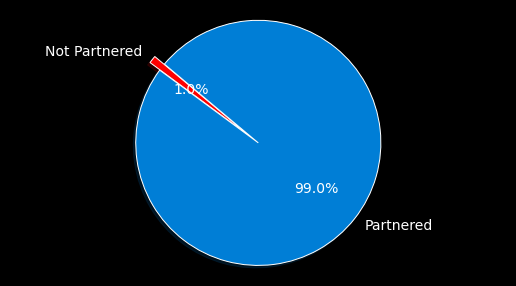

In [97]:
plt.pie(df.head(100).groupby("Partnered").count()["Channel"].values,
        explode=[0.1, 0],
        labels=["Not Partnered", "Partnered"], 
        colors=["#FF0000", "#007ED6"], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140)

plt.axis("equal")
plt.show()

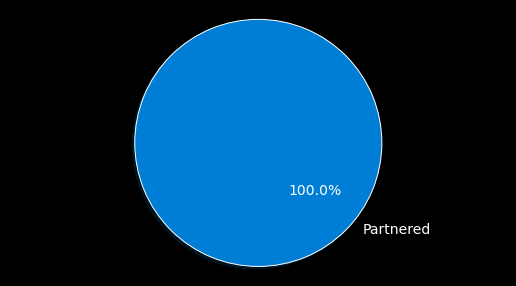

In [105]:
plt.pie(df.head(25).groupby("Partnered").count()["Channel"].values,
        explode=[0.0],
        labels=["Partnered"], 
        colors=["#007ED6"], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140)

plt.axis("equal")
plt.show()

The higher up the food chain, we see a higher prevalence of partnership until every streamer has it. This makes sense, since to be dedicated to Twitch it would make sense to have a partnership if you can.

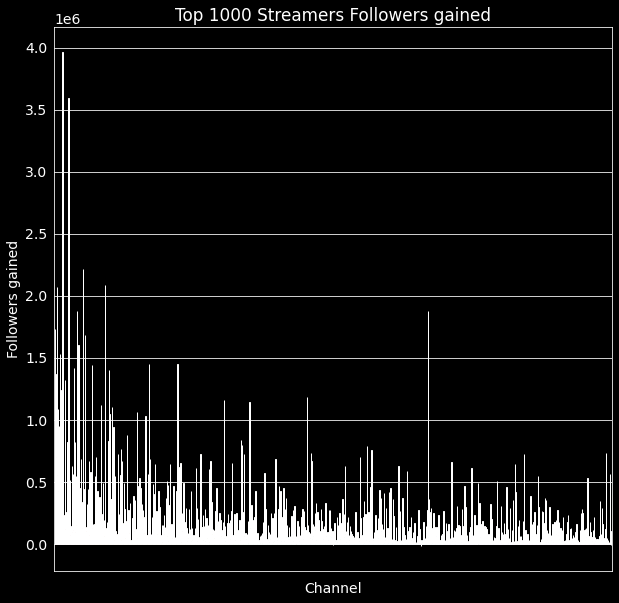

In [106]:
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Followers gained"]).set(xticklabels=[])
plt.title("Top 1000 Streamers Followers gained")
plt.show()

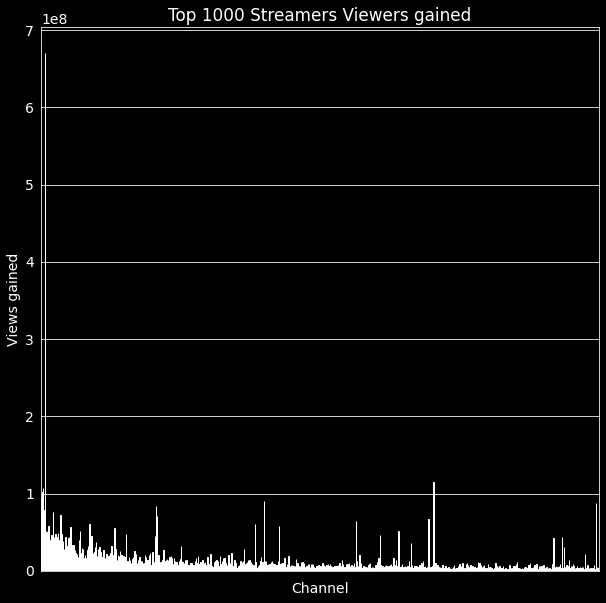

In [108]:
plt.figure(figsize=(10, 10))
sns.barplot(x=df["Channel"], 
            y=df["Views gained"]).set(xticklabels=[])
plt.title("Top 1000 Streamers Viewers gained")
plt.show()

These are charts for followers and viewers gained. This isn't too useful because it only concerns individual channels, but we can see that channels with high outliers must have exploded in popularity and channels with low outliers died in popularity. The correlation between watch time and followers gained is very loose but the correlation between watch time and viewers gained seems more evident.

Now let's explore the earnings dataset. First, let's combine data from the two datasets to make a single dataset that contains the top 100 earners and their Twitch stats.

In [ ]:
df.where(df['Channel']==row['Streamer'])['Watch time(Minutes)'][i]

In [162]:
data = pd.DataFrame(columns=['name', 'rev', 'watch', 'followers'])
for i, row in rev.iterrows():
    try:
        data = data.append({'name': row['Streamer'], 'rev': row['Payout'], 
                        'watch': df.loc[df['Channel']==row['Streamer']].iloc[0]["Watch time(Minutes)"],
                           'followers': df.loc[df['Channel']==row['Streamer']].iloc[0]["Followers"]}, ignore_index=True)
    except:
        print()
data.head()

,name,rev,watch,followers
0,CriticalRole,"$9,626,712.16",539495145,571210
1,xQcOW,"$8,454,427.17",6196161750,3246298
2,summit1g,"$5,847,541.17",6091677300,5310163
3,Tfue,"$5,295,582.44",3671000070,8938903
4,NICKMERCS,"$5,096,642.12",3360675195,4074287


Now let's plot watch time against revenue to see if we find anything interesting.

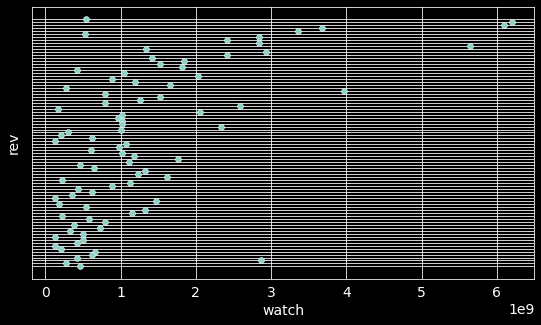

In [160]:
sns.scatterplot(y=data['rev'], x=data['watch']).set(yticklabels=[])
plt.show()

There is a positive correlation between watch time and revenue as we can see in this graph. The shape of the data seems weird, because even though high watch time correlates to high success, low watch time streamers also have a lot of high revenue. Since this is only data for the top 1000 streamers, a lot of those streamers are actually sponsored celebrities or organizations that don't stream full time but still host major popular streams.

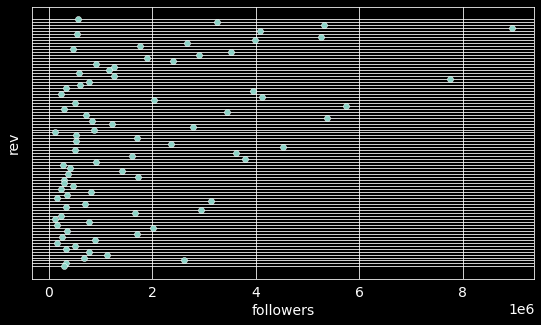

In [164]:
sns.scatterplot(y=data['rev'], x=data['followers']).set(yticklabels=[])
plt.show()

The graph of followers vs. revenue is very similar to watch time vs. revenue.

## Predicting Revenue

Now that we gathered our data and see what we have to work with, let's devise a model for predicting success on Twitch. First, let's employ a linear regression model to find the relationship between revenue and watch time.

In [267]:
# y
# for i , row in data.iterrows():
#     np.insert(y, 0, (data.iloc[i]['rev']))

y = data['rev'].to_numpy()
# y = data['rev'].astype(str)
X = data.drop(['rev','name'],axis=1)
# for i in range(0,84):
#     y[i] = y[i].strip(',')
X.shape, y.shape

((84, 2), (84,))

In [268]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((67, 2), (17, 2))

In [276]:

from sklearn.metrics import mean_squared_error

# instantiate the model
lr = LinearRegression()
# fit the model 
lr.fit(X_train, y_train)

#predicting the target value from the model for the samples
y_test_lr = lr.predict(X_test)
y_train_lr = lr.predict(X_train)

#computing the accuracy of the model performance
acc_train_lr = lr.score(X_train, y_train)
acc_test_lr = lr.score(X_test, y_test)

#computing root mean squared error (RMSE)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_lr))

print("Linear Regression: Accuracy on training Data: {:.3f}".format(acc_train_lr))
print("Linear Regression: Accuracy on test Data: {:.3f}".format(acc_test_lr))
print('\nLinear Regression: The RMSE of the training set is:', rmse_train_lr)
print('Linear Regression: The RMSE of the testing set is:', rmse_test_lr)


ValueError: could not convert string to float: '953,042.02'

This is a linear model for revenue of the top 1000 Twitch streamers. Because the top 1000 are so much different from other Twitch streamers, this can't be used as a general prediction tool, but maybe it can predict success among other top 1000 streamers?

In [275]:
y_hat = lr.predict(X_train)
sns.distplot(y_train - y_hat)
plt.title("Residuals", size=18)
lr.score(X_train,y_train)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Conclusion

Twitch is one of the fastest growing websites in the world and understanding its ecosystem can help us understand Twitch's relationship with its streamers and its role in our culture. With this tutorial, we explored data from Twitch streamers to see if there were any correlations to be found just by observing their Twitch stats and some streamers' revenue. We learned about the Twitch ecosystem and how each statistic affects one another. We also visualized these findings. Finally, we conducted a linear regression to predict revenue on Twitch.